### NOTES
1. need to filter out overlapping predicted bboxs before mAP metrics evaluation??
    - YES! you need to do NMS to remove highly overlapping bboxs (see ```show_preds``` near ```process_output``` from fastai notebook [pascal.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb))
    - In summary the following procedures are needed: 
        - (i) process_output on predictions (for each sample) -- ```process_output```
        - (ii) NMS on predicted bbox and scores -- ```nms```
        - (iii) bbox from CTHW to TLBR format
2. Following up on above, why ```unpad``` is not used (on target bbox and labels)??
3. CTHW really refer H to Height, W to Width? (Why not CTWH)
    - YES! CT = (y, x), HW = (height, width)
4. TLBR is [x0, y0, x1, y1] OR [y0, x0, y1, x1]??
    - [y0, x0, y1, x1]!! Top-Left-Bottom-Right
5. TensorBBox after DataLoaders is in [x0, y0, x1, y1] OR [y0, x0, y1, x1]??
    - it depends on the bbox format before transformation done by BBoxBlock, since my bbox output from ```get_annotations```, its bbox format is in [x0, y0, x1, y1]
6. After ```unpad```, tgt_class is decremented by 1

### Reference
1. [RetinaNet demo -- pascal.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb)

In [1]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

from pathlib import Path
from pdb import set_trace
import warnings
warnings.filterwarnings('ignore')

from fastai2.vision.all import *

from src.data.dblock import build_dblock
from src.data.dls import build_dataloaders
from src.model.model import get_retinanet, split_param_groups
from src.metrics.loss import get_retinanet_loss
from src.metrics.mAP import mAP

%load_ext autoreload
%autoreload 2

### 0. Setup Learner

In [3]:
data_path = Path('/userhome/34/h3509807/wheat-data')
model_path = Path('/userhome/34/h3509807/Wheat-Detection-2020')

dls = build_dataloaders(data_path, bs = 8, 
                        resize_sz = 256, norm = True, 
                        rand_seed = 144, test_mode = True)

len(dls.train.items), len(dls.valid.items)

(96, 24)

In [4]:
model = get_retinanet()
retinanet_loss = get_retinanet_loss(ratios = None, scales = None)
learn = Learner(dls, model, path = model_path,
                loss_func = retinanet_loss,
                splitter = split_param_groups)

In [ ]:
learn.load('final_retinanet_learner')

### 1. Get Model Prediction

In [7]:
b = learn.dls.one_batch()

learn.model.eval()
with torch.no_grad():
    preds = learn.model(b[0])

### 2. Interface Prediction with mAP Metrics

In [24]:
from src.metrics.utils import create_anchors, activ_to_bbox
from src.metrics.utils import tlbr2cthw, cthw2tlbr

In [25]:
def test_process_output(output, i, detect_thresh=0.25):
    """ 
    Process `output[i]` and return the predicted bboxes above `detect_thresh`.
    
    :return:
        bbox_pred : bbox in normalized cthw format
        scores : confidence score after filtering
        preds : class index for a predicted bbox
    """
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    
    scales = [1, 2**(-1/3), 2**(-2/3)]
    ratios = [1/2, 1, 2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    
    # argmax --> sigmoid(.) --> apply threshold
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    
    # still expressed in cthw 
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

### 2a. From BBox Offset (bbox_pred) to BBox CTHW (p_bbox_pred)
- bbox_pred is in batch
- p_bbox_pred is in one sample

In [26]:
clas_pred, bbox_pred, sizes = preds

bbox_pred.shape, bbox_pred[0, :3]

(torch.Size([8, 46836, 4]),
 tensor([[ 0.3300,  0.3040, -0.6704, -1.0501],
         [ 0.4119,  0.2938, -0.4941, -1.0316],
         [ 0.3273,  0.3304, -0.3778, -0.9814]], device='cuda:0'))

In [27]:
p_bbox_pred, p_scores, p_preds = test_process_output(preds, 0, detect_thresh = 0.5)
p_bbox_pred.shape

torch.Size([46456, 4])

In [28]:
p_bbox_pred[:3]

tensor([[-0.9358, -0.8879,  0.1284,  0.2242],
        [-0.9449, -0.9080,  0.1101,  0.1840],
        [-0.9538, -0.9231,  0.0924,  0.1537]], device='cuda:0')

### 2b. Rescale BBox CTHW (p_bbox_pred) to BBox TLBR (tlbr_bbox_pred)
- both p_bbox_pred, tlbr_bbox_pred is in one sample

In [33]:
from src.metrics.utils import cthw2tlbr

In [38]:
test_cthw_bbox = torch.as_tensor([[-0., -0., 0.5, 0.5]])
cthw2tlbr(test_cthw_bbox)

tensor([[-0.2500, -0.2500,  0.2500,  0.2500]])

In [40]:
tlbr_bbox_pred = cthw2tlbr(p_bbox_pred)
tlbr_bbox_pred.shape, tlbr_bbox_pred[:3]

(torch.Size([46456, 4]),
 tensor([[-1.0000, -1.0000, -0.8716, -0.7758],
         [-1.0000, -1.0000, -0.8899, -0.8160],
         [-1.0000, -1.0000, -0.9076, -0.8463]], device='cuda:0'))

### 2c. BBox TLBR (tlbr_bbox_pred) to BBox Orig Scale

In [41]:
from src.metrics.utils import decode_bboxs

In [45]:
scaled_bbox_pred = decode_bboxs(tlbr_bbox_pred, img_size = 256)

In [46]:
scaled_bbox_pred.shape, scaled_bbox_pred[:3]

(torch.Size([46456, 4]),
 tensor([[ 0.0000,  0.0000, 16.4398, 28.7014],
         [ 0.0000,  0.0000, 14.0971, 23.5503],
         [ 0.0000,  0.0000, 11.8308, 19.6754]], device='cuda:0'))

### 3. Distribution of Confidence Scores

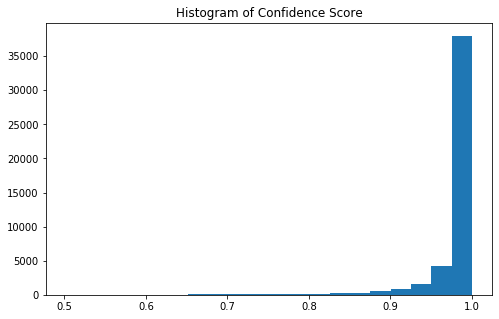

In [63]:
fig, ax = plt.subplots(1, figsize = (8, 5))

hist_data = p_scores.flatten().cpu().numpy()
ax.hist(hist_data, bins = 20)
ax.set_title('Histogram of Confidence Score');

### 4. Predicted Labels v.s. Target Labels

In [95]:
p_preds

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [96]:
tgt_bbox, tgt_clas = b[1][3], b[2][3]
tgt_clas

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')

### 4. Post-Processing on Target BBox and Target Labels

In [92]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    """
    changes:
    - all class labels decremented by 1 (padding label = -1)
    - bbox change from TLBR to CTHW format
    class labels for padding = -1
    """
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

In [90]:
tgt_bbox, tgt_clas = b[1][3], b[2][3]

# target class labels from one sample
tgt_clas.shape, tgt_bbox.shape, tgt_clas, tgt_bbox[:3]

(torch.Size([40]),
 torch.Size([40, 4]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0'),
 tensor([[-1.0000, -0.3242, -0.7871, -0.1328],
         [-0.5391,  0.8613, -0.3457,  1.0000],
         [-0.3047, -0.5098, -0.1367, -0.2441]], device='cuda:0'))

In [91]:
unpad_tgt_bbox, unpad_tgt_clas = unpad(tgt_bbox, tgt_clas, pad_idx = 0)

unpad_tgt_clas.shape, unpad_tgt_bbox.shape, unpad_tgt_clas, unpad_tgt_bbox[:3]

(torch.Size([40]),
 torch.Size([40, 4]),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0, -1, -1], device='cuda:0'),
 tensor([[-0.8936, -0.2285,  0.2129,  0.1914],
         [-0.4424,  0.9307,  0.1934,  0.1387],
         [-0.2207, -0.3770,  0.1680,  0.2656]], device='cuda:0'))

In [80]:
unpad_tgt_clas

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [79]:
tgt_clas.shape, unpad_tgt_clas.shape

(torch.Size([40]), torch.Size([40]))

### 5. Sort scaled_bbox_pred in Descending Order of Scores

In [53]:
clas_pred.shape, p_scores.shape

(torch.Size([8, 46836, 1]), torch.Size([46456]))

In [50]:
p_scores

tensor([0.7086, 0.8301, 0.9394,  ..., 0.7744, 0.7749, 0.5193], device='cuda:0')

In [100]:
idxs = torch.argsort(p_scores, dim = -1, descending = True)
p_scores[idxs]

tensor([1.0000, 1.0000, 1.0000,  ..., 0.5032, 0.5029, 0.5020], device='cuda:0')

In [101]:
p_bbox_pred[idxs]

tensor([[-0.9501, -0.9500,  0.0999,  0.1000],
        [-0.8591, -0.9520,  0.1771,  0.0895],
        [-0.8921, -0.9519,  0.1753,  0.0896],
        ...,
        [-0.9590,  0.5784,  0.0821,  0.0560],
        [-0.1472,  0.1293,  1.3922,  0.7115],
        [-0.3592,  0.9627,  0.0559,  0.0746]], device='cuda:0')

In [102]:
p_preds[idxs]

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')